### 18.4. 트랜스포머

IMDB 영화평 데이터셋 주소

https://www.kaggle.com/datasets/lakshmi25npathi/imdb-dataset-of-50k-movie-reviews

데이터셋 준비 및 학습/테스트 함수 (18.3절과 동일)

In [1]:
using CSV, DataFrames
import MLUtils
import Flux, Optimisers, Zygote, Functors
using Formatting: printfmtln
using TextAnalysis
using Random: MersenneTwister

function prepare_corpus()
    imdb = CSV.read("/home/tyfun/Downloads/IMDB Dataset.csv", DataFrame)
    X = replace.(imdb.review, "<br />" => " ")
    X = X.|> tokenize

    X_crps = Corpus(TokenDocument.(X))
    prepare!(X_crps, strip_corrupt_utf8)
    prepare!(X_crps, strip_case)
    prepare!(X_crps, stem_words)
    prepare!(X_crps, strip_non_letters)
    prepare!(X_crps, strip_articles)
    prepare!(X_crps, strip_prepositions)
    prepare!(X_crps, strip_pronouns)
    prepare!(X_crps, strip_stopwords)

    imdb, X_crps
end

function get_data(num_words, seq_len, batch_size)
    imdb, X_crps = prepare_corpus()
    
    update_lexicon!(X_crps)
    lexi = lexicon(X_crps)
    sorted = map(x -> x[1], sort(collect(lexi), by = x->x[2], rev=true))
    top_words = first(filter(x -> x != "", sorted), num_words)
    word_idx = Dict(x => i + 1 for (i, x) in enumerate(top_words))     
    
    X = map(X_crps) do crp
        idx = map(x -> get(word_idx, x, 0), crp.tokens)
        idx = filter(x -> x != 0, idx)
        if length(idx) > seq_len
            idx[1:seq_len]
        else
            vcat(idx, fill(1, seq_len - length(idx)))
        end
    end
    X = MLUtils.batch(X)
    
    y = ifelse.(imdb.sentiment .== "positive", 1, 0);
    y = Flux.onehotbatch(y, 0:1)

    train, test = MLUtils.splitobs((X, y), at = 0.7);
    train_loader = MLUtils.DataLoader(train, batchsize=batch_size)
    test_loader = MLUtils.DataLoader(test, batchsize=batch_size)
    
    train_loader, test_loader, top_words
end

function train(loader, model, loss_fn, optimizer)
    num_batches = length(loader)
    losses = Float32[]
    Flux.testmode!(model, false)
    for (batch, (X, y)) in enumerate(loader)
        X, y = Flux.gpu(X), Flux.gpu(y)
        grad = Zygote.gradient(m -> loss_fn(m, X, y), model)[1]
        optimizer, model = Optimisers.update(optimizer, model, grad)
        if batch % 100 == 0
            loss = loss_fn(model, X, y)
            printfmtln("[Train] loss: {:.7f} [{:>3d}/{:>3d}]", 
                loss, batch, num_batches)
            push!(losses, loss)
        end
    end
    model, optimizer, losses
end

function test(loader, model, loss_fn)
    num_batches = length(loader)
    Flux.testmode!(model, true)
    acc, tot = 0, 0
    loss = 0f0
    for (X, y) in loader
        X, y = Flux.gpu(X), Flux.gpu(y)
        pred = model(X)
        acc += sum(Flux.onecold(pred) .== Flux.onecold(y))
        tot += batch_size
        loss += loss_fn(model, X, y)
    end
    acc, avg_loss = acc / tot * 100, loss / num_batches
    printfmtln("[Test] Accuracy: {:.1f}, Avg loss: {:.7f}", 
        acc, avg_loss)
    acc, avg_loss
end

function run_batch(loaders, models, epochs)
    train_loader, test_loader = loaders
    loss_fn(m, X, y) = Flux.Losses.logitcrossentropy(m(X), y)
    train_losses, accuracies = [], []
    for (k, model) in enumerate(models)
        train_loss, accuracy = [], []
        optimizer = Optimisers.setup(Optimisers.Adam(), model)
        for t in 1:epochs
            println("[Model $k] Epoch $t")
            println("-------------------------------")
            model, optimizer, loss = 
                train(train_loader, model, loss_fn, optimizer)
            train_loss = vcat(train_loss, loss)
            acc, _ = test(test_loader, model, loss_fn)
            push!(accuracy, acc)
        end
        push!(train_losses, train_loss)
        push!(accuracies, accuracy)
    end
    train_losses, accuracies
end


run_batch (generic function with 1 method)

In [2]:
num_words = 10000;
seq_len = 300;
batch_size = 64;

train_loader, test_loader, top_words = get_data(num_words, seq_len, batch_size);

모델 정의

In [3]:
using Transformers

In [4]:
struct MyTrns
    embed       # 단어 임베딩
    pos_emb     # 위치 임베딩
    trns       # 트랜스포머
    pool        # 풀링
    dense1      # 밀집층 1
    dropout     # 드랍아웃
    dense2      # 밀집층 2
end
Functors.@functor MyTrns

function (a::MyTrns)(X)             # (seq, bat)
    X = a.embed(X) .+ a.pos_emb(X)  # (emb, seq, bat)
    X = a.trns((; hidden_state = X)).hidden_state # (emb, seq, bat)
    X = permutedims(X, (2,1,3))     # (seq, emb, bat)
    X = dropdims(a.pool(X), dims=1) # (emb, bat)
    X = a.dense1(a.dropout(X))
    a.dense2(a.dropout(X))
end

In [26]:
function build_model(emb; head = 4, hs = 64, preLN = false)
    embed = Flux.Embedding(emb)
    embed_size = size(embed.weight, 1)
    pos_emb = Layers.SinCosPositionEmbed(embed_size)
    block = preLN ? Layers.PreNormTransformerBlock : Layers.TransformerBlock 
    num_layer = 2
    head_hidden = embed_size ÷ head
    ffn_dim = 4 * embed_size
    trns = Transformer(block, num_layer, head, embed_size, head_hidden, ffn_dim)
    MyTrns(
        embed,
        pos_emb, 
        trns,
        #trns2,
        Flux.GlobalMeanPool(),
        Flux.Dense(embed_size => hs, Flux.relu),
        Flux.Dropout(0.5), 
        Flux.Dense(hs => 2))
end

build_model (generic function with 1 method)

학습 결과

In [27]:
embed_size = 128;

model_base = build_model(num_words + 1 => embed_size, hs = 64)

models = [model_base] .|> Flux.gpu
losses, accus = run_batch((train_loader, test_loader), models, 10);

[Model 1] Epoch 1
-------------------------------
[Train] loss: 0.6623523 [100/547]
[Train] loss: 0.6722148 [200/547]
[Train] loss: 0.4938729 [300/547]
[Train] loss: 0.4677532 [400/547]
[Train] loss: 0.4796938 [500/547]
[Test] Accuracy: 78.6, Avg loss: 0.4577569
[Model 1] Epoch 2
-------------------------------
[Train] loss: 0.3408290 [100/547]
[Train] loss: 0.4609420 [200/547]
[Train] loss: 0.1935228 [300/547]
[Train] loss: 0.3431971 [400/547]
[Train] loss: 0.2653749 [500/547]
[Test] Accuracy: 83.3, Avg loss: 0.3969790
[Model 1] Epoch 3
-------------------------------
[Train] loss: 0.3152088 [100/547]
[Train] loss: 0.4255472 [200/547]
[Train] loss: 0.1815214 [300/547]
[Train] loss: 0.2605925 [400/547]
[Train] loss: 0.2531321 [500/547]
[Test] Accuracy: 83.2, Avg loss: 0.3906603
[Model 1] Epoch 4
-------------------------------
[Train] loss: 0.2707590 [100/547]
[Train] loss: 0.2949248 [200/547]
[Train] loss: 0.2556390 [300/547]
[Train] loss: 0.1499204 [400/547]
[Train] loss: 0.1787175 [

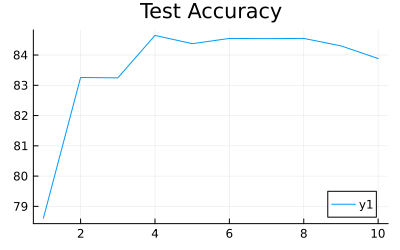

In [28]:
import Plots
Plots.gr(size=(400,250))
Plots.plot(accus, title="Test Accuracy")

정규화 순서 바꾸기

In [29]:
model_base = build_model(num_words + 1 => embed_size, hs = 64, preLN = true)
models = [model_base] .|> Flux.gpu
losses, accus = run_batch((train_loader, test_loader), models, 10);

[Model 1] Epoch 1
-------------------------------
[Train] loss: 0.7120354 [100/547]
[Train] loss: 0.5714824 [200/547]
[Train] loss: 0.4036425 [300/547]
[Train] loss: 0.4568099 [400/547]
[Train] loss: 0.3785609 [500/547]
[Test] Accuracy: 79.3, Avg loss: 0.4433808
[Model 1] Epoch 2
-------------------------------
[Train] loss: 0.4127350 [100/547]
[Train] loss: 0.4052534 [200/547]
[Train] loss: 0.2962696 [300/547]
[Train] loss: 0.3750716 [400/547]
[Train] loss: 0.2720879 [500/547]
[Test] Accuracy: 83.2, Avg loss: 0.3745776
[Model 1] Epoch 3
-------------------------------
[Train] loss: 0.3145852 [100/547]
[Train] loss: 0.3593948 [200/547]
[Train] loss: 0.2044910 [300/547]
[Train] loss: 0.2771748 [400/547]
[Train] loss: 0.1818190 [500/547]
[Test] Accuracy: 85.0, Avg loss: 0.3450129
[Model 1] Epoch 4
-------------------------------
[Train] loss: 0.2796110 [100/547]
[Train] loss: 0.2908418 [200/547]
[Train] loss: 0.1727996 [300/547]
[Train] loss: 0.1865539 [400/547]
[Train] loss: 0.1906131 [

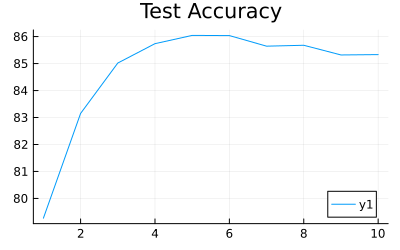

In [30]:
import Plots
Plots.gr(size=(400,250))
Plots.plot(accus, title="Test Accuracy")